In [25]:
# load package
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import einops
import torch.nn.functional as F
from torch import nn
from PIL import Image

In [26]:
# load visionts source code
import sys
sys.path.append('../')
from src.visionts import VisionTS
from src.visionts.util import *

In [27]:
# load pretrain model
ARCH = 'mae_base' # choose from {'mae_base', 'mae_large', 'mae_huge'}. We recommend 'mae_base'
DEVICE = 'cuda:0'
# The following code will automatically download MAE (base) checkpoint file into ./ckpt/ if not exists.
model = VisionTS(ARCH, ckpt_dir='./ckpt/').to(DEVICE)

/home/siruzhong/projects/TimeMM/tutorial/../src/visionts/model.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location='cpu')


In [28]:
# load data and args
data_name = 'electricity/electricity.csv'
data = pd.read_csv('../dataset/'+data_name, parse_dates=['date'], index_col='date')
target_col = 'OT'
seq_len = 300
horizon = 96

# Compare the prediction with the ground truth
# 设置对齐常量、归一化常量和周期性
align_const = 0.9
norm_const = 0.4
periodicity = 7  # 假设每周周期性

print(data.head())

                        0     1      2      3      4       5     6       7  \
date                                                                         
2016-07-01 02:00:00  14.0  69.0  234.0  415.0  215.0  1056.0  29.0   840.0   
2016-07-01 03:00:00  18.0  92.0  312.0  556.0  292.0  1363.0  29.0  1102.0   
2016-07-01 04:00:00  21.0  96.0  312.0  560.0  272.0  1240.0  29.0  1025.0   
2016-07-01 05:00:00  20.0  92.0  312.0  443.0  213.0   845.0  24.0   833.0   
2016-07-01 06:00:00  22.0  91.0  312.0  346.0  190.0   647.0  16.0   733.0   

                         8      9  ...    311    312      313     314     315  \
date                               ...                                          
2016-07-01 02:00:00  226.0  265.0  ...  676.0  372.0  80100.0  4719.0  5002.0   
2016-07-01 03:00:00  271.0  340.0  ...  805.0  452.0  95200.0  4643.0  6617.0   
2016-07-01 04:00:00  270.0  300.0  ...  817.0  430.0  96600.0  4285.0  6571.0   
2016-07-01 05:00:00  179.0  211.0  ...  801.0  2

In [29]:
# Define util function that shows data as time serie and image

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image.cpu() * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')

def run(x, y, align_const, norm_const, periodicity):
    # The input of VisionTS is a Tensor with shape [n_batch, context_len, n_vars]
    x = torch.Tensor(einops.rearrange(x, 't -> 1 t 1')).to(DEVICE)
    # The output of VisionTS is a Tensor with shape [n_batch, pred_len, n_vars]
    y = torch.Tensor(einops.rearrange(y, 't -> 1 t 1')).to(DEVICE)
    # Before calling forward, make sure you use update_config() to update hyperparameters, context length or prediction length.
    model.update_config(x.shape[1], y.shape[1], align_const=align_const, norm_const=norm_const, periodicity=periodicity)
    # Forecasting time series using forward()
    with torch.no_grad():
        y_pred, input_image, reconstructed_image = model.forward(x, export_image=True)

    # Visualization
    x = x[:, -seq_len:, :]
    plt.subplot(2, 2, 1)
    show_image(input_image[0, 0], 'input')

    plt.subplot(2, 2, 2)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.title('input time series')
    plt.legend()
    plt.tight_layout()

    plt.subplot(2, 2, 3)
    show_image(reconstructed_image[0, 0], 'reconstructed')

    plt.subplot(2, 2, 4)
    plt.plot(x.cpu()[0, :, 0])
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y.cpu()[0, :, 0], label='true', alpha=0.5)
    plt.plot(torch.arange(y.shape[1]) + x.shape[1], y_pred.cpu()[0, :, 0], label='pred')
    plt.title('forecasting')
    plt.legend()
    plt.tight_layout()

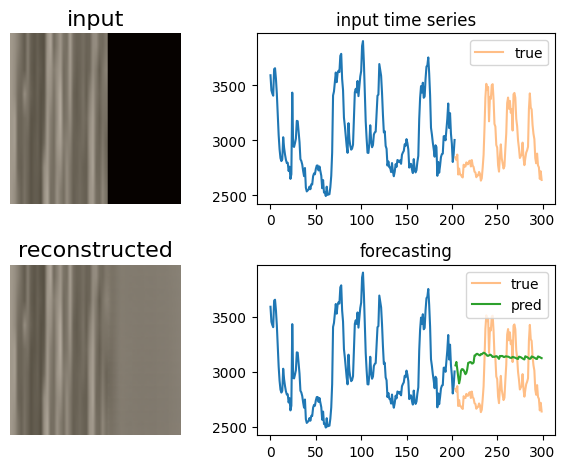

In [30]:
# 假设使用 'total_usage' 列
x = data[target_col].values[-seq_len:-horizon]  # 取过去 500 个时间步作为输入
y = data[target_col].values[-horizon:]  # 取未来 50 个时间步作为预测目标

# 使用之前定义的 run 函数
run(x, y, align_const=align_const, norm_const=norm_const, periodicity=periodicity)